# BDMLtools制作评分卡并与scorecardpy对比  <font size=3 >by 曾珂</font>

**环境**:
+ **OS**: macOS Big Sur 11.5.2
+ **CPU**: 2GHz 四核Intel Core i5
+ **内存**: 16G

In [1]:
import scorecardpy as sc
import BDMLtools as bm
import pandas as pd

In [2]:
bm.__version__

'0.3.0'

In [3]:
sc.__version__

'0.1.9.2'

+ load germancredit data

In [4]:
dt=sc.germancredit().copy()
dt['creditability']=dt['creditability'].map({'good':0,'bad':1})

+ 将germancredit的有序category类型转换为有序数值类型

In [5]:
da=bm.dtypeAllocator().fit(dt)
dt=da.transform(dt)

In [6]:
X=dt.drop('creditability',axis=1)
y=dt['creditability']

## 制作评分卡

### 产生特征分析报告

In [7]:
breaks_list_user={'age.in.years': [26.0, 30.0, 35.0],
 'credit.amount': [4000.0, 6200.0, 8000.0],
 'credit.history': [2.0, 3.0, 4.0],
 'duration.in.month': [8.0, 16.0, 44.0],
 'foreign.worker': [1],
 'housing': [1.0],
 'installment.rate.in.percentage.of.disposable.income': [2.0, 3.0, 4.0],
 'job': [2.0, 3.0],
 'number.of.existing.credits.at.this.bank': [2.0],
 'number.of.people.being.liable.to.provide.maintenance.for': [2.0],
 'other.debtors.or.guarantors': [2.0],
 'other.installment.plans': [2.0],
 'personal.status.and.sex': [2.0, 3.0],
 'present.employment.since': [2.0, 3.0],
 'present.residence.since': [2.0],
 'property': [1.0, 2.0, 3.0],
 'purpose': ['retraining%,%car (used)',
  'radio/television',
  'furniture/equipment%,%domestic appliances%,%business',
  'repairs%,%car (new)%,%others%,%education'],
 'savings.account.and.bonds': [1.0, 2.0, 3.0],
 'status.of.existing.checking.account': [1.0, 2.0, 3.0],
 'telephone': [1.0]}

In [8]:
%%time
bin_sc=sc.woebin(dt,y='creditability',breaks_list=breaks_list_user,no_cores=1)

[INFO] creating woe binning ...
CPU times: user 643 ms, sys: 13.6 ms, total: 656 ms
Wall time: 662 ms


In [9]:
%%time
bin_bm=bm.varReport(breaks_list_dict=breaks_list_user,n_jobs=1).fit(X,y).var_report_dict

CPU times: user 329 ms, sys: 7.71 ms, total: 337 ms
Wall time: 334 ms


### woe编码

In [10]:
%%time
dt_woe_sc = sc.woebin_ply(dt, bins=bin_sc,no_cores=1)

[INFO] converting into woe values ...
CPU times: user 366 ms, sys: 11.3 ms, total: 378 ms
Wall time: 374 ms


In [11]:
%%time
dt_woe_bm = bm.woeTransformer(varbin=bin_bm,n_jobs=1).transform(X,y)

CPU times: user 120 ms, sys: 4.72 ms, total: 125 ms
Wall time: 129 ms


+ 对比两份数据的编码结果

In [12]:
dt_woe_sc_1=dt_woe_sc.loc[:,dt_woe_sc.columns.str.contains('woe')]
dt_woe_sc_1.columns=[i[:-4] for i in dt_woe_sc_1.columns]
dt_woe_sc_1=dt_woe_sc_1[dt_woe_bm.columns]

+ 两者数值上几乎无区别，低精度类型条件下数值相等

In [13]:
dt_woe_sc_1.astype('float32').equals(dt_woe_bm.astype('float32')) #结果对比

True

### 回归建模

In [14]:
from sklearn.linear_model import LogisticRegression

+ 使用lr建模

In [15]:
lr_sc = LogisticRegression(penalty='l1',C=0.9,solver='saga').fit(dt_woe_sc_1, y)

In [16]:
lr_bm = LogisticRegression(penalty='l1',C=0.9,solver='saga').fit(dt_woe_bm, y)

In [17]:
lr_sc.coef_

array([[0.61137618, 0.88738403, 0.648283  , 0.64219903, 0.72710905,
        0.72100524, 1.65428829, 0.        , 0.        , 0.        ,
        0.96038618, 0.63857889, 0.        , 0.55408442, 0.        ,
        0.4090616 , 1.01362942, 0.77096776, 0.78982491, 0.58570925]])

In [18]:
lr_bm.coef_

array([[0.61137747, 0.88738067, 0.64828788, 0.64219473, 0.72710997,
        0.72100848, 1.65429077, 0.        , 0.        , 0.        ,
        0.96038868, 0.63857859, 0.        , 0.55407838, 0.        ,
        0.40906821, 1.01362025, 0.77097562, 0.78982829, 0.58569801]])

In [19]:
lr_sc.feature_names_in_[lr_bm.coef_[0]==0]

array(['job', 'number.of.existing.credits.at.this.bank',
       'number.of.people.being.liable.to.provide.maintenance.for',
       'personal.status.and.sex', 'present.residence.since'], dtype=object)

+ 制作评分卡

    这里scorecardpy产生评分卡时会去掉系数为0的特征,而bm会保留这些特征
    + 这种区别不会对后续打分带来任何影响,因为系数为0时score_point也为0

In [20]:
card_sc = sc.scorecard(bin_sc, lr_sc, dt_woe_sc_1.columns,
                           points0=600,
                           odds0=0.05263157894736842,
                           pdo=50)

In [21]:
card_obj = bm.cardScorer(lr_bm,bin_bm,
                        odds0=0.05263157894736842,
                        pdo=50,
                        points0=600).fit(X)

#bm.cardScorer可支持sklearn的LogisticRegression,也可支持statsmodels的glm-logit回归或logit回归

card_bm = card_obj.scorecard

In [22]:
print(len(card_sc),len(card_bm))

16 21


+ BDMLtools的特征分析报告文件中,任何变量都会存在missing水平,用以标示缺失值或特殊值,

    + 数据无缺失的时missing的woe为0,因此points为0,不会对打分产生任何影响
    + 若希望赋予missing值特殊的woe(比如woe较高(风险较大)),可以通过bm.cardScorer的woe_missing参数设定,这也是BMDLtools的特色
    + 更多细节请参考帮助文档

In [23]:
pd.concat(card_bm)[['points']].head(13)

points
intercept     intercept          449.0
age.in.years  [-inf, 26.0)       -23.0
              [26.0, 30.0)        -3.0
              [30.0, 35.0)        -2.0
              [35.0, inf)         14.0
              special             -0.0
              missing             -0.0
credit.amount [-inf, 4000.0)      13.0
              [4000.0, 6200.0)   -22.0
              [6200.0, 8000.0)   -25.0
              [8000.0, inf)      -65.0
              special             -0.0
              missing             -0.0

In [24]:
pd.concat(card_sc)[['variable','bin','points']].head(9)

variable              bin  points
basepoints    0      basepoints              NaN   449.0
age.in.years  53   age.in.years      [-inf,26.0)   -23.0
              54   age.in.years      [26.0,30.0)    -3.0
              55   age.in.years      [30.0,35.0)    -2.0
              56   age.in.years       [35.0,inf)    14.0
credit.amount 27  credit.amount    [-inf,4000.0)    13.0
              28  credit.amount  [4000.0,6200.0)   -22.0
              29  credit.amount  [6200.0,8000.0)   -25.0
              30  credit.amount     [8000.0,inf)   -65.0

+ 对比得分结果

In [25]:
%%time
dt_score_sc=sc.scorecard_ply(dt,card_sc)

CPU times: user 422 ms, sys: 10.3 ms, total: 432 ms
Wall time: 441 ms



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
%%time
dt_score_bm=card_obj.transform(X)

CPU times: user 111 ms, sys: 5.51 ms, total: 117 ms
Wall time: 119 ms


In [27]:
dt_score_sc['score'].equals(dt_score_bm['score'])

True

## 1.2 模型评估 

In [28]:
y_pred=pd.Series(lr_bm.predict_proba(dt_woe_bm)[:,1],index=dt_woe_bm.index)
y_score=dt_score_sc['score']

bm.perfEval提供了与R scorecard::perf_eval一致的模型评估功能，能够产生常见的二分类排序模型的评估图:
            
+ 'ks':ks曲线
+ 'lift':lift曲线
+ 'gain':gain曲线
+ 'roc':roc曲线
+ 'pr':pr曲线
+ 'lz':lorenz曲线
+ 'f1':f1曲线
+ 'density':核密度分布曲线

可通过参数bm.perfEval的参数show_plot进行指定

方法plot用于绘制这些评估图，使用见帮助文档，方法plot产生结果为字典，结构为{图类型:图形...},可方便进行进一步处理

In [29]:
%%time
plotter=bm.perfEval(show_plot=('ks', 'lift', 'gain', 'roc', 'lz', 'pr', 'f1', 'density'), title='german-credit')
figs_proba=plotter.plot(y_pred,y,group=None,figure_size=(5,5))

CPU times: user 899 ms, sys: 26 ms, total: 925 ms
Wall time: 272 ms


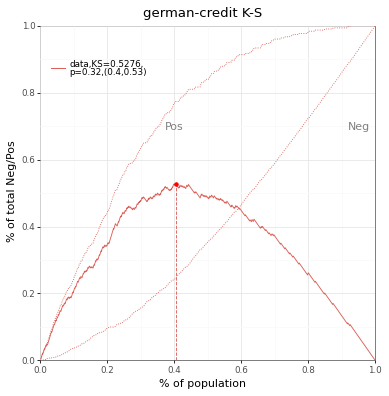

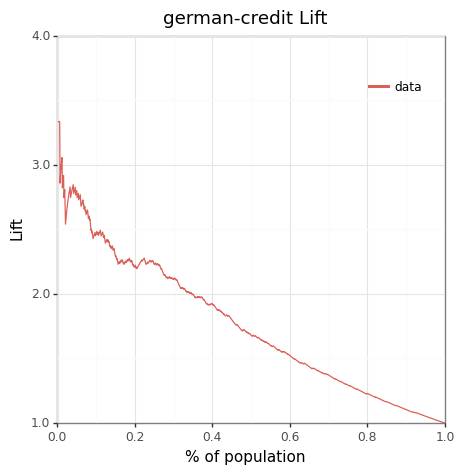

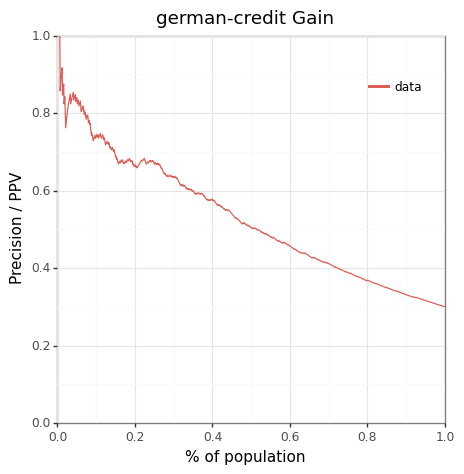

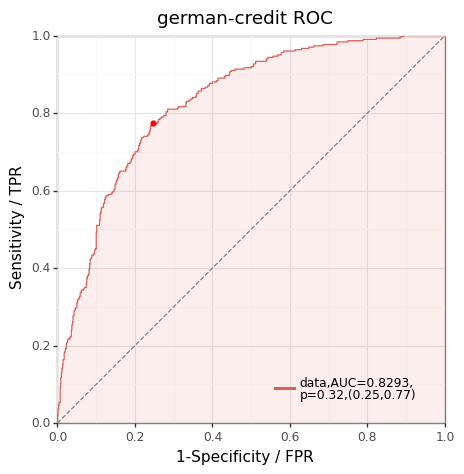

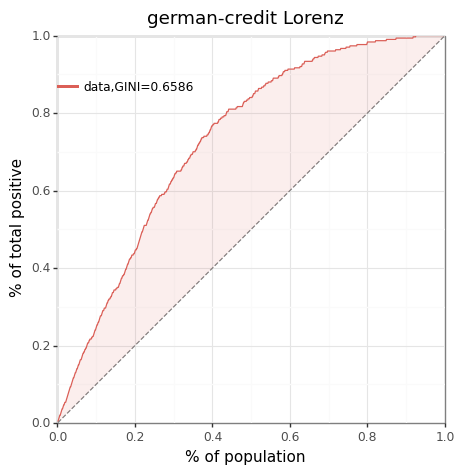

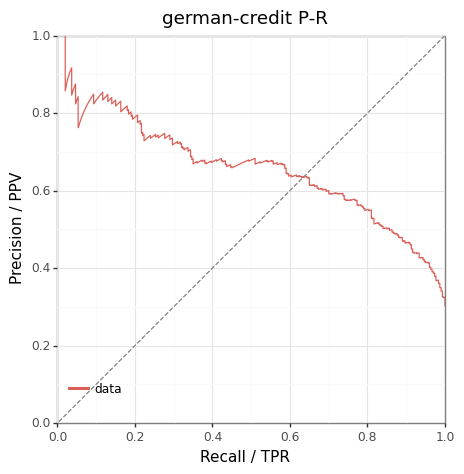

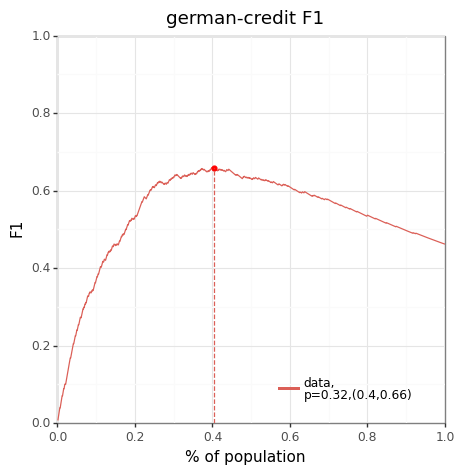

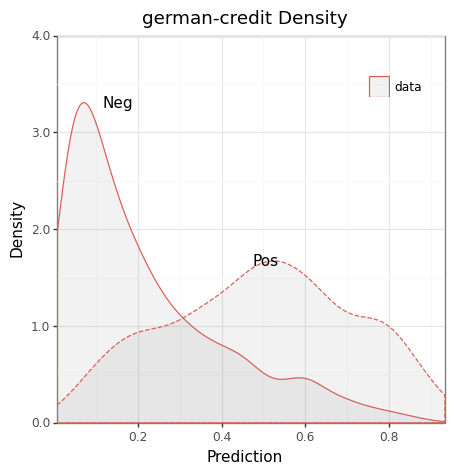

{'ks': <ggplot: (8775442983415)>,
 'lift': <ggplot: (8775442982184)>,
 'gain': <ggplot: (8775442964152)>,
 'roc': <ggplot: (8775442964342)>,
 'lz': <ggplot: (8775443798303)>,
 'pr': <ggplot: (8775442887476)>,
 'f1': <ggplot: (8775443827460)>,
 'density': <ggplot: (8775442880076)>}

In [30]:
figs_proba

这里不仅可对预测概率进行评估，以可以对评分进行评估

In [31]:
%%time
plotter=bm.perfEval(show_plot=('ks', 'lift', 'gain', 'roc', 'lz', 'pr', 'f1', 'density'), title='german-credit-score')
figs_score=plotter.plot(y_score,y,group=None,figure_size=(5,5))

CPU times: user 360 ms, sys: 10 ms, total: 370 ms
Wall time: 259 ms


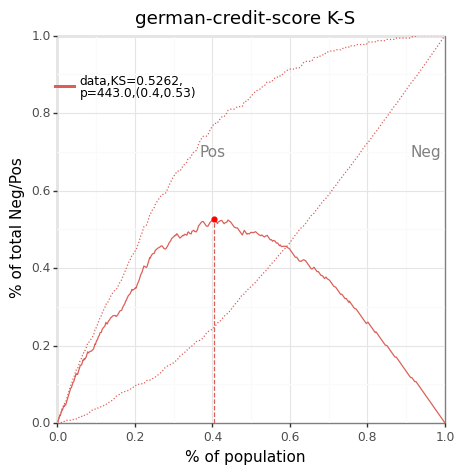

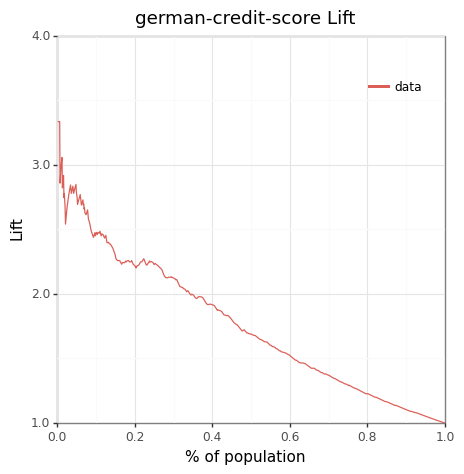

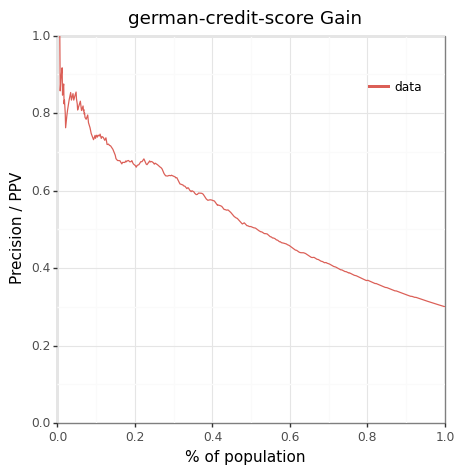

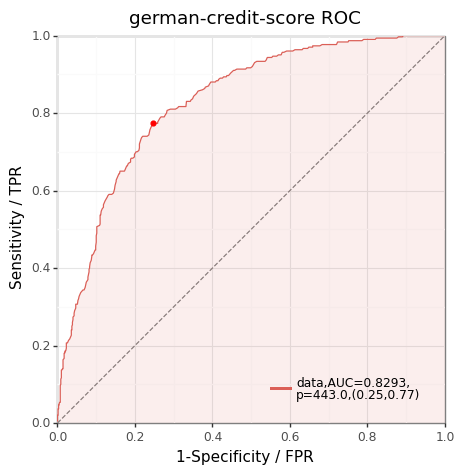

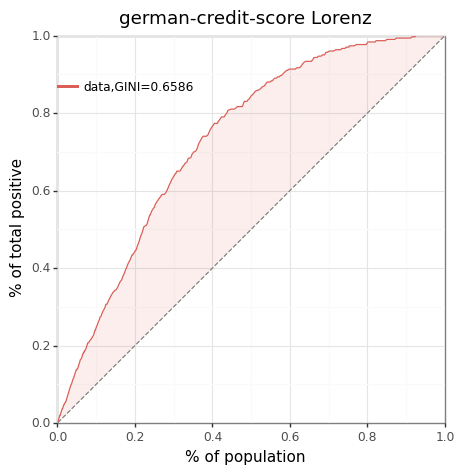

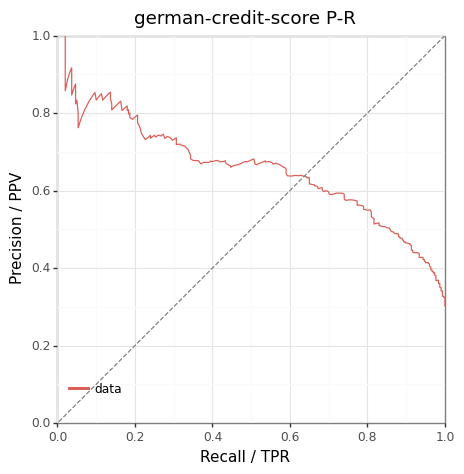

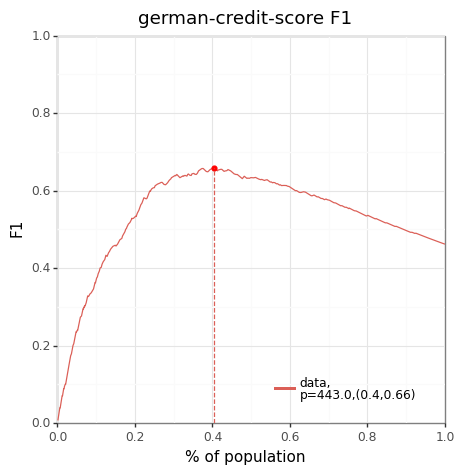

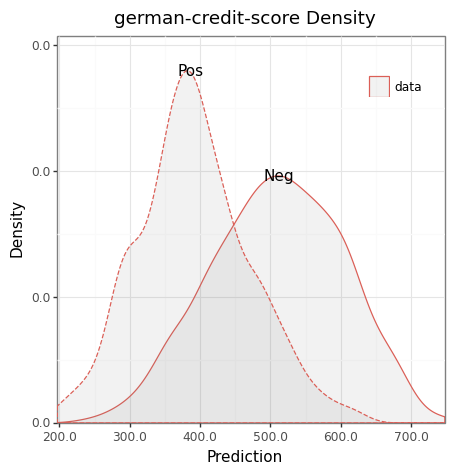

{'ks': <ggplot: (8775445239028)>,
 'lift': <ggplot: (8775443270906)>,
 'gain': <ggplot: (8775443277587)>,
 'roc': <ggplot: (8775443275524)>,
 'lz': <ggplot: (8775443281541)>,
 'pr': <ggplot: (8775443395042)>,
 'f1': <ggplot: (8775445239263)>,
 'density': <ggplot: (8775443259103)>}

In [32]:
figs_score